In [1]:
cd ../../data

/Users/lise/memoire_tech/M2_HN/data


In [41]:
#Librairies classiques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import base64
from tqdm import tqdm

#Librairies géographiques
import osmnx as ox
import geopandas
from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster
from folium.plugins import MiniMap
from folium import IFrame
from folium.plugins import HeatMap

In [3]:
#Récupération des données
with open("textile_clean.csv") as csv :
    df_textile = pd.read_csv(csv, sep="\t")

### Modification des adresses qui pose problème ensuite au moment récupération 

In [4]:
#Suppression des numéros dans les adresses (problèmes des sites archéologiques)
df_textile['production site']=df_textile['production site'].replace(r'(\d+)','', regex=True)
df_textile['find site']=df_textile['find site'].replace(r'(\d+)','', regex=True)

In [5]:
#Création de sous-dataframe à partir desquels nous allons travaillé
df_find = df_textile[['ID','find site']]
df_production = df_textile[['ID', 'production site']]

#Réglage d'erreurs de langue (anglais/espagnol) sur les éléments 45 et 58 du find site: 
df_find.at[58, ('find site')] = 'Peru, Central coast'
df_find.at[45, ('find site')] = 'Peru, Central coast'


# _Découpage des adresses_ : pays, région, village
# PAYS
## Cas pour production site

In [8]:
#Récupération des noms de pays
liste_pays = []
liste_region = []
liste_adresse = []

for elt in df_production["production site"] :
    liste_adresse.append([elt])

for adresse in liste_adresse : 
    for elt in adresse :
        elt = elt.replace(', ', ',')
        elt = elt.split(',')
        elt = list(set(elt))
        #print(elt)
        for i in range(len(elt)) : 
            try :
                if (elt[i] == "Bolivia"  or elt[i] == "Peru" or elt[i] == "Chile" or elt[i] == "Argentina") :
                    liste_pays.append(elt[i])
                    elt.remove(elt[i])
                    liste_region.append(elt)
                    
            except IndexError :
                continue


country = pd.Series(liste_pays)
region = pd.Series(liste_region)

geo_df_production_temp = df_production.copy()
geo_df_production_temp["country"] = country
geo_df_production_temp["region"] = region 

geo_df_production_temp

,ID,production site,country,region
0,ILCA_ASU001,"Ayllu Tinkipaya, Bolivia, Central Interandean ...",Bolivia,"[Ayllu Tinkipaya, Central Interandean Valleys]"
1,ILCA_ASU002,"Bolivia, Calcha, Southern Interandean Valleys",Bolivia,"[Calcha, Southern Interandean Valleys]"
2,ILCA_ASU003,"Bolivia, Calcha, Southern Interandean Valleys",Bolivia,"[Calcha, Southern Interandean Valleys]"
3,ILCA_ASU004,"Ayllu Tinkipaya, Bolivia, Central Interandean ...",Bolivia,"[Ayllu Tinkipaya, Central Interandean Valleys]"
4,ILCA_ASU005,"Bolivia, Central Interandean Valleys, Ravelo",Bolivia,"[Ravelo, Central Interandean Valleys]"
...,...,...,...,...
691,ILCA_VAM024,"Central coast, Peru",Peru,[Central coast]
692,ILCA_VAM025,"Central coast, Pachacamac, Peru",Peru,"[Pachacamac, Central coast]"
693,ILCA_VAM026,"Central coast, Peru",Peru,[Central coast]
694,ILCA_VAM027,"Paracas, Peru, South coast",Peru,"[South coast, Paracas]"


## Cas pour find site
Besoin de traiter les NaN en plus

In [9]:
#Récupération des noms de pays
liste_pays = []
liste_region = []
liste_adresse = []


for elt in df_find['find site'].fillna("0") : #Remplacement des valeurs vides par des 0
    liste_adresse.append(elt)
    
for elt in liste_adresse : #Traitement des valeurs vides au moment de la boucle pour indiquer s'il manque pays
    if elt == "0" : 
        liste_pays.append("0")
        liste_region.append("0")
    else :
        elt = elt.replace(', ', ',')
        elt = elt.split(',')
        elt = list(set(elt))
        for i in range(len(elt)) : 
            try :
                if (elt[i] == "Bolivia"  or elt[i] == "Peru" or elt[i] == "Chile" or elt[i] == "Argentina") :
                    liste_pays.append(elt[i])
                    elt.remove(elt[i])
                    liste_region.append(elt)

            except IndexError :
                continue


country = pd.Series(liste_pays)
region = pd.Series(liste_region)

geo_df_find_temp = df_find.copy()
geo_df_find_temp["country"] = country
geo_df_find_temp["region"] = region

geo_df_find_temp

,ID,find site,country,region
0,ILCA_ASU001,"Ayllu Tinkipaya, Bolivia, Central Interandean ...",Bolivia,"[Ayllu Tinkipaya, Central Interandean Valleys]"
1,ILCA_ASU002,"Bolivia, Calcha, Southern Interandean Valleys",Bolivia,"[Calcha, Southern Interandean Valleys]"
2,ILCA_ASU003,"Bolivia, Calcha, Southern Interandean Valleys",Bolivia,"[Calcha, Southern Interandean Valleys]"
3,ILCA_ASU004,"Ayllu Tinkipaya, Bolivia, Central Interandean ...",Bolivia,"[Ayllu Tinkipaya, Central Interandean Valleys]"
4,ILCA_ASU005,"Bolivia, Central Interandean Valleys, Ravelo",Bolivia,"[Ravelo, Central Interandean Valleys]"
...,...,...,...,...
691,ILCA_VAM024,"Central coast, Lima, Peru",Peru,"[Central coast, Lima]"
692,ILCA_VAM025,"Central coast, Lima, Peru",Peru,"[Central coast, Lima]"
693,ILCA_VAM026,"Central coast, Lima, Peru",Peru,"[Central coast, Lima]"
694,ILCA_VAM027,"Peru, South coast",Peru,[South coast]


# REGIONS
## Cas pour production site

In [11]:
#Ligne qui permet d'éviter un problème au moment du géocodage (https://en.wikipedia.org/wiki/Chawaytiri pour écriture Chahuatiri)
geo_df_production_temp['region'][188] = ['Northern Interandean Valleys', 'Charazani']

In [12]:
#On récupère les catégories régionales standardisées
liste_loc_prod = []
liste_region_prod = []
liste_adresse_prod = []

for elt in geo_df_production_temp['region'] :
    liste_adresse_prod.append(elt)

for elt in liste_adresse_prod : 
    
    if elt == [] : 
        liste_region_prod.append("0")
        liste_loc_prod.append("0")
    else :
        elt = list(set(elt))
        for i in range(3) : 
            try :
                if ("Valleys" in elt[i] or "Altiplano" in elt[i] or "coast" in elt[i] or "sierra" in elt[i] or "Argentina" in elt[i] or "Basin" in elt[i] or "Interior" in elt[i]) :
                    liste_region_prod.append(elt[i])
                    elt.remove(elt[i])
                    liste_loc_prod.append(elt)
                    
            except IndexError :
                continue

liste_loc_prod_clean = []

for elt in liste_loc_prod :  
    elt = str(elt)
    elt = elt.replace("[", "")
    elt = elt.replace("]", "")
    elt = elt.replace("'", "")
    elt = elt.replace('"', '')
    liste_loc_prod_clean.append(elt)

#On récupère les localisations plus précises    
region = pd.Series(liste_region_prod)
city = pd.Series(liste_loc_prod_clean)


geo_df_production = geo_df_production_temp.copy()
geo_df_production["region"] = region
geo_df_production["place"] = city

#Modifications pour géocoder le plus de lieux possibles : 
for i in geo_df_production[['place']].columns:
    geo_df_production[i].replace("","Rapa Nui",inplace=True)
    geo_df_production[i].replace("Ayllu Tinkipaya","Tinguipaya",inplace=True)
    geo_df_production[i].replace("0","Rapa Nui",inplace=True) #Attribution d'une valeur aberrante sur l'île de Paques qui appartient au Chili
    geo_df_production[i].replace("Rinconada de Santa Clara","Rapa Nui",inplace=True)
    geo_df_production[i].replace("Western valleys","Rapa Nui",inplace=True)
    geo_df_production[i].replace("Mesothermic Intermontane Valleys","Rapa Nui",inplace=True)
    geo_df_production[i].replace("Noreste de Argentina","Rapa Nui",inplace=True)
    geo_df_production[i].replace("Charazani-Sanipalla","Charazani",inplace=True)
    geo_df_production[i].replace("Ayllu Macha","Municipio Potosí",inplace=True)
    geo_df_production[i].replace("Ayllus Norte Potosí","Municipio Potosí",inplace=True)
    geo_df_production[i].replace("Cora Cora-Salinas de Garcí Mendoza","Salinas de Garcí Mendoza",inplace=True)
    geo_df_production[i].replace("Region of lake Titicaca","Lake Titicaca",inplace=True)
    geo_df_production[i].replace("Islas del lago Titicaca","Lake Titicaca",inplace=True)
    geo_df_production[i].replace("Tiwanaku","Lake Titicaca",inplace=True)
    geo_df_production[i].replace("Killpani","Kilpani",inplace=True)
    geo_df_production[i].replace("Playa Miller 4","Arica city",inplace=True)
    geo_df_production[i].replace("Playa Miller 3","Arica city",inplace=True)
    geo_df_production[i].replace("Playa Miller 6","Arica city",inplace=True)
    geo_df_production[i].replace("Playa Miller 9","Arica city",inplace=True)
    geo_df_production[i].replace("Estación ferroviaria Yura","Estación Yura",inplace=True)
    geo_df_production[i].replace("Yura","Estación Yura",inplace=True)
    geo_df_production[i].replace("Faldas del Morro","Morro de Arica",inplace=True)
    geo_df_production[i].replace("Azapa 70","Quebrada del Diablo Arica",inplace=True)
    geo_df_production[i].replace("Azapa 71","Quebrada del Diablo Arica",inplace=True)
    geo_df_production[i].replace("Azapa 140","Quebrada del Diablo Arica",inplace=True)
    geo_df_production[i].replace("Jukumani-Laymi","Chayanta",inplace=True)
    geo_df_production[i].replace("Ayllu Laymi","Chayanta",inplace=True)
    geo_df_production[i].replace("Quitor 1","Quitor",inplace=True)
    geo_df_production[i].replace("Quitor 2","Quitor",inplace=True)
    geo_df_production[i].replace("Coyo Oriente","Coyo",inplace=True)
    geo_df_production[i].replace("Paracas (Necrópolis)","Paracas",inplace=True)
    geo_df_production[i].replace("Compi","Compi, Bolivia",inplace=True)
    geo_df_production[i].replace("Ayllu Qaqachaka","Kaka Chaca",inplace=True) #Province !
    geo_df_production[i].replace("Ayllu K'ultha","Kaka Chaca",inplace=True)#Province !
    geo_df_production[i].replace("Ayllu Kultha","Kaka Chaca",inplace=True)#Province !
    geo_df_production[i].replace("Qaqachaka-Livichuco","Rapa Nui",inplace=True)#Province !
    geo_df_production[i].replace("Chawaytiri","Chahuaytiri",inplace=True)
    geo_df_production[i].replace("Chanchan","Chan Chan",inplace=True)
    geo_df_production[i].replace("Pacajes","Rapa Nui",inplace=True)#Province !
    geo_df_production[i].replace("Pacajes norte","Rapa Nui",inplace=True)#Province !
    geo_df_production[i].replace("Azaroma","Ollachea",inplace=True)
    geo_df_production[i].replace("Qeros","Qero Grande",inplace=True) #Nom de culture plutôt ? 
    geo_df_production[i].replace("Jesús de Machaqa","Jesús de Machaca",inplace=True)
    geo_df_production[i].replace("Ayllu Pocoata","Pocoata",inplace=True)
    geo_df_production[i].replace("Cochabamba valleys","Cochabamba",inplace=True)
    geo_df_production[i].replace("Japo","Japo Oruro",inplace=True)
    geo_df_production[i].replace("San Lucas","San Lucas Chuquisaca",inplace=True)
    geo_df_production[i].replace("Carangas","Curahuara de Carangas",inplace=True)
    geo_df_production[i].replace("Bolívar","Provincia Bolívar Bolivia",inplace=True)
    geo_df_production[i].replace("Ichma","Pachacamac",inplace=True) #Nom de culture
    geo_df_production[i].replace("Chuquibamba","Chuquibamba Arequipa",inplace=True)
    geo_df_production[i].replace("Oruro, Marshy region","Oruro",inplace=True) #Region
    geo_df_production[i].replace("Marshy region, Oruro","Oruro",inplace=True) #Region!
        
    
    #Modifications post-géocodage pour améliorer performances
    geo_df_production[i].replace("Lima","Lima Metropolitana",inplace=True)
    geo_df_production[i].replace("Choquecancha","Choquecancha Lares",inplace=True)
    geo_df_production[i].replace("Huari","Rapa Nui",inplace=True) #Indique culture et non lieu
    geo_df_production[i].replace("Sacaca","Sacaca Bolivia",inplace=True)
    geo_df_production[i].replace("Puno Pukara","Rapa Nui",inplace=True) #Indique une pukara (site archéo vers Puno) mais côté bolivien --> indication de localisation insuffisante
    geo_df_production[i].replace("Challa","Rapa Nui",inplace=True) #Deux possibilités dans Central Altiplano = pas possible de déterminer
    geo_df_production[i].replace("Mollo Bolivia","Mollo Grande Bolivia",inplace=True)
    geo_df_production[i].replace("Mollo","Mollo Grande Bolivia",inplace=True)
    geo_df_production[i].replace("Andamarca","Andamarca Oruro",inplace=True)
    geo_df_production[i].replace("Potosí","Municipio Potosí",inplace=True)
    
    

geo_df_production

,ID,production site,country,region,place
0,ILCA_ASU001,"Ayllu Tinkipaya, Bolivia, Central Interandean ...",Bolivia,Central Interandean Valleys,Tinguipaya
1,ILCA_ASU002,"Bolivia, Calcha, Southern Interandean Valleys",Bolivia,Southern Interandean Valleys,Calcha
2,ILCA_ASU003,"Bolivia, Calcha, Southern Interandean Valleys",Bolivia,Southern Interandean Valleys,Calcha
3,ILCA_ASU004,"Ayllu Tinkipaya, Bolivia, Central Interandean ...",Bolivia,Central Interandean Valleys,Tinguipaya
4,ILCA_ASU005,"Bolivia, Central Interandean Valleys, Ravelo",Bolivia,Central Interandean Valleys,Ravelo
...,...,...,...,...,...
691,ILCA_VAM024,"Central coast, Peru",Peru,Central coast,Rapa Nui
692,ILCA_VAM025,"Central coast, Pachacamac, Peru",Peru,Central coast,Pachacamac
693,ILCA_VAM026,"Central coast, Peru",Peru,Central coast,Rapa Nui
694,ILCA_VAM027,"Paracas, Peru, South coast",Peru,South coast,Paracas


## Cas pour find site

In [13]:
#Ligne qui permet d'éviter un problème au moment du géocodage
#Je regarde à quoi 'Rinconada de Santa Clara' est associée dans le DF original (juste Pérou et localisation introuvable)
#Ajout d'un 0 pour qu'il soit comptabilisé ensuite
geo_df_find_temp['region'][91] = ["0", 'Rinconada de Santa Clara']

In [20]:
#On récupère les catégories régionales standardisées
liste_loc_find = []
liste_region_find = []
liste_adresse_find = []

for elt in geo_df_find_temp['region'] :
    liste_adresse_find.append(elt)
    
for elt in liste_adresse_find : 
    if (elt == '0' or elt == []) : 
        liste_region_find.append("0")
        liste_loc_find.append("0")
        
    else :
        elt = list(set(elt))
        for i in range(3) : 
            try :
                if ("Valleys" in elt[i] or "Altiplano" in elt[i] or "coast" in elt[i] or "sierra" in elt[i] or "Argentina" in elt[i] or "Basin" in elt[i] or "Interior" in elt[i] or "0" in elt[i]) :
                    liste_region_find.append(elt[i])
                    elt.remove(elt[i])
                    liste_loc_find.append(elt)
                    
            except IndexError :
                continue

#On récupère les localisations plus précises 
liste_loc_find_clean = []

for elt in liste_loc_find :  
    elt = str(elt)
    elt = elt.replace("[", "")
    elt = elt.replace("]", "")
    elt = elt.replace("'", "")
    elt = elt.replace('"', '')
    liste_loc_find_clean.append(elt)
    
region = pd.Series(liste_region_find)
city = pd.Series(liste_loc_find_clean)

geo_df_find = geo_df_find_temp.copy()
geo_df_find["region"] = region
geo_df_find["place"] = city

#Modifications pour géocoder le plus de lieux possibles : 
for i in geo_df_find[['place']].columns:
    geo_df_find[i].replace("","Rapa Nui",inplace=True)
    geo_df_find[i].replace("Ayllu Tinkipaya","Tinguipaya",inplace=True)
    geo_df_find[i].replace("0","Rapa Nui",inplace=True) #Attribution d'une valeur aberrante sur l'île de Paques qui appartient au Chili
    geo_df_find[i].replace("Rinconada de Santa Clara","Rapa Nui",inplace=True)
    geo_df_find[i].replace("Western valleys","Rapa Nui",inplace=True)
    geo_df_find[i].replace("Mesothermic Intermontane Valleys","Rapa Nui",inplace=True)
    geo_df_find[i].replace("Noreste de Argentina","Rapa Nui",inplace=True)
    geo_df_find[i].replace("Charazani-Sanipalla","Charazani",inplace=True)
    geo_df_find[i].replace("Ayllu Macha","Municipio Potosí",inplace=True)
    geo_df_find[i].replace("Ayllus Norte Potosí","Municipio Potosí", inplace=True)
    geo_df_find[i].replace("Cora Cora-Salinas de Garcí Mendoza","Salinas de Garcí Mendoza", inplace=True)
    geo_df_find[i].replace("Region of lake Titicaca","Lake Titicaca", inplace=True)
    geo_df_find[i].replace("Islas del lago Titicaca","Lake Titicaca", inplace=True)
    geo_df_find[i].replace("Killpani","Kilpani", inplace=True)
    geo_df_find[i].replace("Estación ferroviaria Yura","Estación Yura", inplace=True)
    geo_df_find[i].replace("Yura","Estación Yura", inplace=True)
    geo_df_find[i].replace("Faldas del Morro","Morro de Arica", inplace=True)
    geo_df_find[i].replace("Jukumani-Laymi","Chayanta", inplace=True)
    geo_df_find[i].replace("Ayllu Laymi","Chayanta", inplace=True)
    geo_df_find[i].replace("Solcor ","Solcor", inplace=True)
    geo_df_find[i].replace("Quitor ","Quitor", inplace=True)
    geo_df_find[i].replace("Paracas (Necrópolis)","Paracas", inplace=True)
    geo_df_find[i].replace("Compi","Compi Bolivia", inplace=True)
    geo_df_find[i].replace("Ayllu Qaqachaka","Kaka Chaca", inplace=True)
    geo_df_find[i].replace("Ayllu K'ultha","Kaka Chaca", inplace=True)
    geo_df_find[i].replace("Ayllu Kultha","Kaka Chaca", inplace=True)
    geo_df_find[i].replace("Qaqachaka-Livichuco","Rapa Nui", inplace=True)
    geo_df_find[i].replace("Chawaytiri","Chahuaytiri", inplace=True)
    geo_df_find[i].replace("Chanchan","Chan Chan", inplace=True)
    geo_df_find[i].replace("Pacajes","Rapa Nui", inplace=True)
    geo_df_find[i].replace("Pacajes norte","Rapa Nui", inplace=True)
    geo_df_find[i].replace("Azaroma","Ollachea", inplace=True)
    geo_df_find[i].replace("Qeros","Qero Grande", inplace=True)
    geo_df_find[i].replace("Jesús de Machaqa","Jesús de Machaca", inplace=True)
    geo_df_find[i].replace("Ayllu Pocoata","Pocoata", inplace=True)
    geo_df_find[i].replace("Japo","Japo Oruro", inplace=True)
    geo_df_find[i].replace("Cochabamba valleys","Cochabamba", inplace=True)
    geo_df_find[i].replace("Trujillo","Trujillo Peru", inplace=True)
    geo_df_find[i].replace("Marshy region, Oruro","Oruro",inplace=True) #Region!

    
    #Modifications post-géocodage pour améliorer performances
    geo_df_find[i].replace("Lima","Lima Metropolitana",inplace=True)
    geo_df_find[i].replace("Huari","Rapa Nui",inplace=True) #Indique culture plus que lieu
    geo_df_find[i].replace("Sacaca","Sacaca Bolivia",inplace=True)
    geo_df_find[i].replace("Puno Pukara","Rapa Nui",inplace=True)#Indique une pukara (site archéo vers Puno) mais côté bolivien --> indication de localisation insuffisante
    geo_df_find[i].replace("La Libertad","Rapa Nui",inplace=True) #Région
    geo_df_find[i].replace("Nasca","Nasca Peru",inplace=True)
    geo_df_find[i].replace("Bolívar","Bolívar Cochabamba",inplace=True)
    geo_df_find[i].replace("Coyo Oriente","Coyo",inplace=True)
    geo_df_find[i].replace("Azapa ","Quebrada del Diablo Arica",inplace=True)
    geo_df_find[i].replace("Andamarca","Andamarca Oruro",inplace=True)
    geo_df_find[i].replace("Playa Miller ","Arica city", inplace=True)
    geo_df_find[i].replace("Omasuyos","Achacachi", inplace=True) #Ville centrale de la province
    geo_df_find[i].replace("Potolo","Potolo Sucre", inplace=True) #Ville centrale de la province
    
    
geo_df_find

,ID,find site,country,region,place
0,ILCA_ASU001,"Ayllu Tinkipaya, Bolivia, Central Interandean ...",Bolivia,Central Interandean Valleys,Tinguipaya
1,ILCA_ASU002,"Bolivia, Calcha, Southern Interandean Valleys",Bolivia,Southern Interandean Valleys,Calcha
2,ILCA_ASU003,"Bolivia, Calcha, Southern Interandean Valleys",Bolivia,Southern Interandean Valleys,Calcha
3,ILCA_ASU004,"Ayllu Tinkipaya, Bolivia, Central Interandean ...",Bolivia,Central Interandean Valleys,Tinguipaya
4,ILCA_ASU005,"Bolivia, Central Interandean Valleys, Ravelo",Bolivia,Central Interandean Valleys,Ravelo
...,...,...,...,...,...
691,ILCA_VAM024,"Central coast, Lima, Peru",Peru,Central coast,Lima Metropolitana
692,ILCA_VAM025,"Central coast, Lima, Peru",Peru,Central coast,Lima Metropolitana
693,ILCA_VAM026,"Central coast, Lima, Peru",Peru,Central coast,Lima Metropolitana
694,ILCA_VAM027,"Peru, South coast",Peru,South coast,Rapa Nui


## Décompte du nombre de textiles pour les catégories pays et région 

In [21]:
count_textile_per_country_prod = geo_df_production.groupby(['country'],
    as_index=True,
)['country'].count()
count_textile_per_country_prod = pd.DataFrame(count_textile_per_country_prod)
count_textile_per_country_prod.columns = ['count_country']
count_textile_per_country_prod.reset_index(inplace=True)
count_textile_per_country_prod.columns = ['name','count_country']

print("COUNTRY \n \n" "PRODUCTION \n", count_textile_per_country_prod, "\n")

count_textile_per_country_find = geo_df_find.groupby(['country'],
    as_index=True,
)['country'].count()


count_textile_per_country_find = pd.DataFrame(count_textile_per_country_find)
count_textile_per_country_find.columns = ['count_country']
count_textile_per_country_find.reset_index(inplace=True)
count_textile_per_country_find.columns = ['name','count_country']

print("FIND \n", count_textile_per_country_find)


COUNTRY 
 
PRODUCTION 
         name  count_country
0  Argentina              2
1    Bolivia            401
2      Chile             70
3       Peru            223 

FIND 
       name  count_country
0        0            317
1  Bolivia            156
2    Chile             62
3     Peru            161


# Cartographie de la répartition textile

## Par PAYS

                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((-69.64501 -17.28159, -69.64500 -17.2...   -9.668944  -22.898274   
1  POLYGON ((-84.63565 -4.70132, -84.63506 -4.754...   -0.039282  -20.198447   
2  MULTIPOLYGON (((-109.67958 -27.20000, -109.679...  -17.498383  -56.725000   
3  MULTIPOLYGON (((-73.56054 -49.94247, -73.56048...  -21.780857  -55.192571   

   bbox_east   bbox_west  place_id  osm_type  osm_id        lat        lon  \
0 -57.453000  -69.645007  43641685  relation  252645 -17.056870 -64.991229   
1 -68.651991  -84.635654  35448662  relation  288247  -6.869970 -75.045851   
2 -66.075347 -109.679579  34614939  relation  167454 -31.761336 -71.318770   
3 -53.637451  -73.560537  49181870  relation  286393 -34.996496 -64.967282   

      class            type  place_rank  importance addresstype       name  \
0  boundary  administrative           4    0.733355     country    Bolivia   
1  boundary  administrative           4    0.762406 

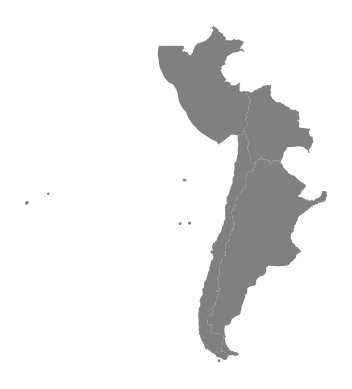

In [22]:
# Récupération des frontières de Bolivie, du Pérou, du Chili et de l'Argentine via Open Street Map
gdf_countries = ox.geocode_to_gdf(["Bolivia", "Peru", "Chili", "Argentina"])
print(gdf_countries)

countries_proj = ox.project_gdf(gdf_countries)
ax = countries_proj.plot(fc="grey", ec="none")
_ = ax.axis("off")

#NB : pour le Pérou, frontière maritime plus large = pas d'alignement entre les frontières péruviennes et chilienne

In [23]:
#Décompte des textiles associés aux géométries des pays

#Cas des lieux de production
textile_count_countries_prod = gdf_countries.merge(
    count_textile_per_country_prod,
    on='name',
    how='left',
)
textile_count_countries_prod

#Cas des lieux de découverte
#On laisse de côté la valeur 0 pour qu'elle ne pose pas problèmes au moment du merge
count_textile_per_country_find = count_textile_per_country_find.drop(index=0)
count_textile_per_country_find

textile_count_countries_find = gdf_countries.merge(
    count_textile_per_country_find,
    on='name',
    how='left',
)
textile_count_countries_find

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name,count_country
0,"POLYGON ((-69.64501 -17.28159, -69.64500 -17.2...",-9.668944,-22.898274,-57.453000,-69.645007,43641685,relation,252645,-17.056870,-64.991229,boundary,administrative,4,0.733355,country,Bolivia,Bolivia,156.0
1,"POLYGON ((-84.63565 -4.70132, -84.63506 -4.754...",-0.039282,-20.198447,-68.651991,-84.635654,35448662,relation,288247,-6.869970,-75.045851,boundary,administrative,4,0.762406,country,Peru,Peru,161.0
2,"MULTIPOLYGON (((-109.67958 -27.20000, -109.679...",-17.498383,-56.725000,-66.075347,-109.679579,34614939,relation,167454,-31.761336,-71.318770,boundary,administrative,4,0.778342,country,Chile,Chile,62.0
3,"MULTIPOLYGON (((-73.56054 -49.94247, -73.56048...",-21.780857,-55.192571,-53.637451,-73.560537,49181870,relation,286393,-34.996496,-64.967282,boundary,administrative,4,0.810104,country,Argentina,Argentina,NaN


<Axes: >

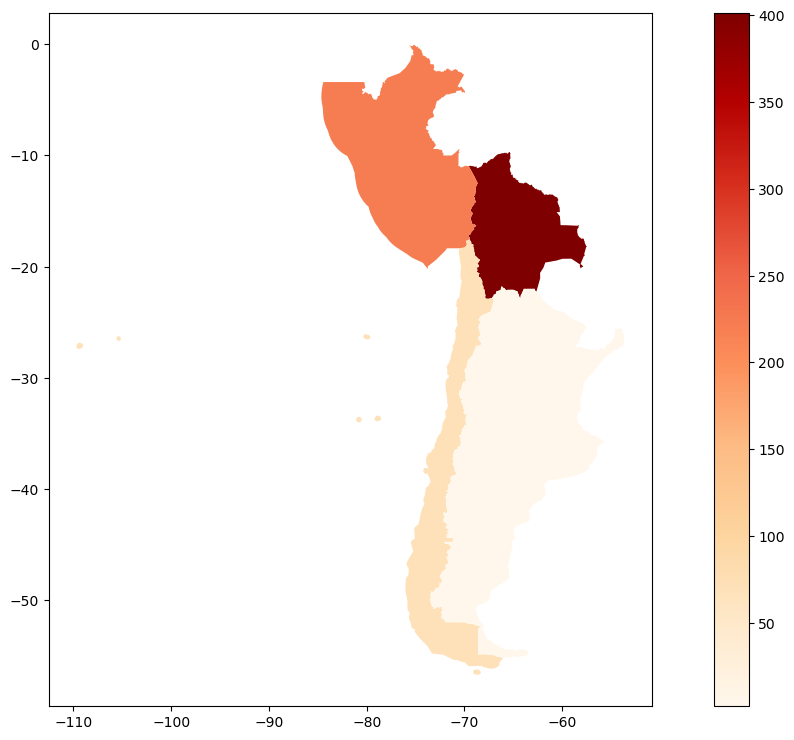

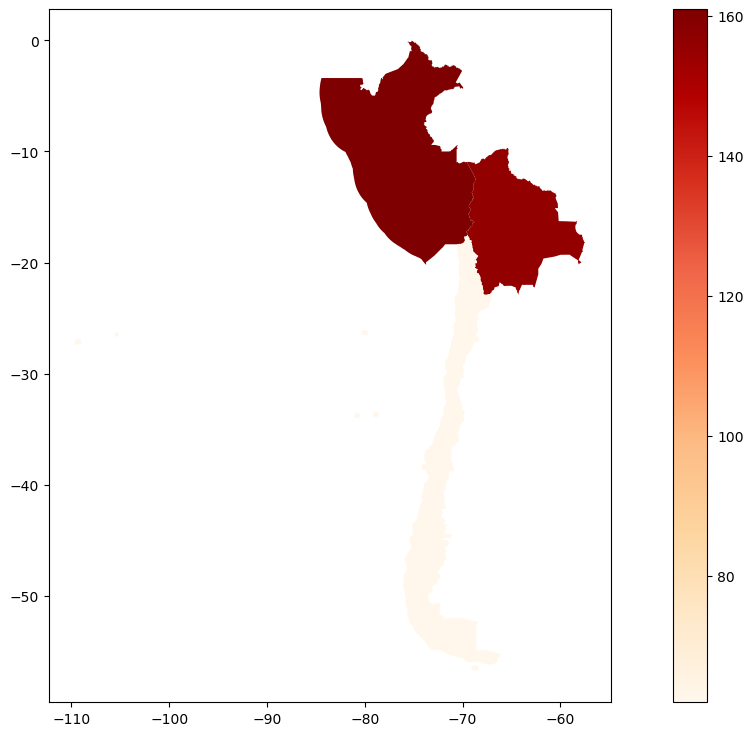

In [25]:
#Représentations cartographiques
textile_count_countries_prod.plot(
    column='count_country',
    figsize=(16, 9),
    cmap='OrRd', #cmap='magma'
    legend=True,
)

textile_count_countries_find.plot(
    column='count_country',
    figsize=(16, 9),
    cmap='OrRd', #cmap='magma'
    legend=True,
)

## Par REGION

Création des régions sur QGIS

    id               Name                                           geometry
0    0        North coast  POLYGON ((-78.17975 -10.07898, -78.20002 -10.0...
1    1      Central coast  POLYGON ((-78.20002 -10.08896, -77.60203 -9.76...
2    2        South coast  POLYGON ((-76.53613 -13.88622, -76.07184 -13.6...
3    3        Arica coast  POLYGON ((-70.36466 -18.35937, -70.30753 -18.3...
4    4     Arica Interior  POLYGON ((-69.74661 -17.65895, -69.65054 -17.6...
5    5      Atacama Basin  POLYGON ((-70.08344 -21.42282, -69.84789 -21.4...
6    6                NOA  POLYGON ((-63.98218 -22.13301, -64.36038 -22.9...
7    8       South sierra  POLYGON ((-75.63436 -13.36168, -74.02159 -12.7...
8    9    North Altiplano  POLYGON ((-69.12449 -15.24663, -69.24068 -15.1...
9   10  Central Altiplano  POLYGON ((-66.80681 -17.12977, -65.92396 -17.2...
10  11    South Altiplano  POLYGON ((-63.19807 -20.34090, -63.17422 -21.4...
11   7     Central Sierra  POLYGON ((-77.15607 -10.59747, -75.89573 -10.1...

<Axes: >

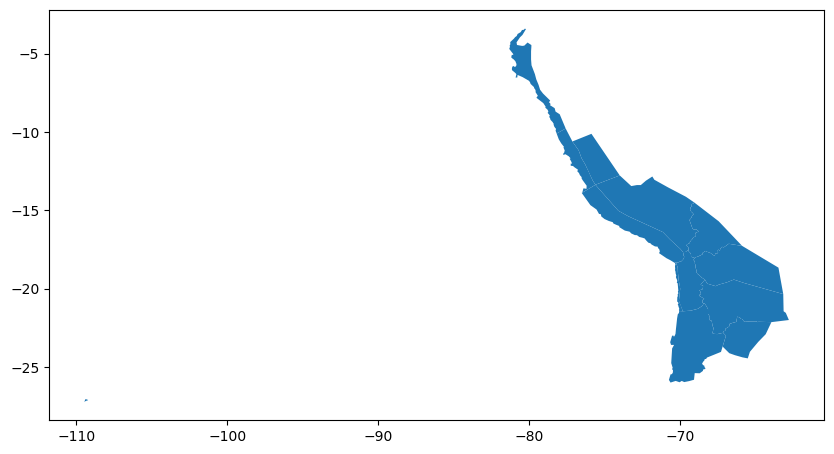

In [29]:
gdf_region = geopandas.read_file("geo_data/WCP_region3.shp", crs=4326)

print(gdf_region)
gdf_region["geometry"].plot(figsize=(10, 10))

### Homégénéisation des données régionales

In [30]:
for i in geo_df_production[['region']].columns:
    geo_df_production[i].replace("Central Interandean Valleys","Central Altiplano",inplace=True)
    geo_df_production[i].replace("Central sierra","Central Sierra",inplace=True)
    geo_df_production[i].replace("Southern Interandean Valleys","South Altiplano",inplace=True)
    geo_df_production[i].replace("Northern Interandean Valleys","North Altiplano",inplace=True)
    geo_df_production[i].replace("Mesothermic Intermontane Valleys","NOA",inplace=True)
    geo_df_production[i].replace("0","Rapa Nui",inplace=True)

In [31]:
for i in geo_df_find[['region']].columns:
    geo_df_find[i].replace("Central sierra","Central Sierra",inplace=True)
    geo_df_find[i].replace("Central Interandean Valleys","Central Altiplano",inplace=True)
    geo_df_find[i].replace("Southern Interandean Valleys","South Altiplano",inplace=True)
    geo_df_find[i].replace("Northern Interandean Valleys","North Altiplano",inplace=True)
    geo_df_find[i].replace("Mesothermic Intermontane Valleys","NOA",inplace=True)
    geo_df_find[i].replace("0","Rapa Nui",inplace=True)

In [34]:
#Décompte des textiles associés aux géométries des pays
#Cas des lieux de production
count_textile_per_region_prod = geo_df_production.groupby(['region'],
    as_index=True,
)['region'].count()

count_textile_per_region_prod = pd.DataFrame(count_textile_per_region_prod)
count_textile_per_region_prod.columns = ['count_region']
count_textile_per_region_prod.reset_index(inplace=True)
count_textile_per_region_prod.columns = ['Name','count_region']


print("REGION \n \n", "PRODUCTION \n", count_textile_per_region_prod, "\n")


#Cas des lieux de découverte
count_textile_per_region_find = geo_df_find.groupby(['region'],
    as_index=True,
)['region'].count()

count_textile_per_region_find = pd.DataFrame(count_textile_per_region_find)
count_textile_per_region_find.columns = ['count_region']
count_textile_per_region_find.reset_index(inplace=True)
count_textile_per_region_find.columns = ['Name','count_region']

print("FIND \n", count_textile_per_region_find)

REGION 
 
 PRODUCTION 
                  Name  count_region
0      Arica Interior            31
1         Arica coast            31
2       Atacama Basin             7
3   Central Altiplano           136
4      Central Sierra             1
5       Central coast            91
6                 NOA             2
7     North Altiplano           229
8         North coast            17
9            Rapa Nui             5
10    South Altiplano            35
11        South coast            77
12       South sierra            34 

FIND 
                  Name  count_region
0      Arica Interior            23
1         Arica coast            26
2       Atacama Basin            12
3   Central Altiplano            75
4       Central coast            76
5     North Altiplano            41
6         North coast            10
7            Rapa Nui           340
8     South Altiplano            35
9         South coast            40
10       South sierra            18


In [35]:
#Création d'un dataframe avec décompte et informations géographiques
textile_count_region_prod = gdf_region.merge(
    count_textile_per_region_prod,
    on='Name',
    how='left',
)

#Pour find on drop la valeur 0 pour qu'elle ne pose pas problème au moment de la fusion
textile_count_region_find = gdf_region.merge(
    count_textile_per_region_find,
    on='Name',
    how='left',
)

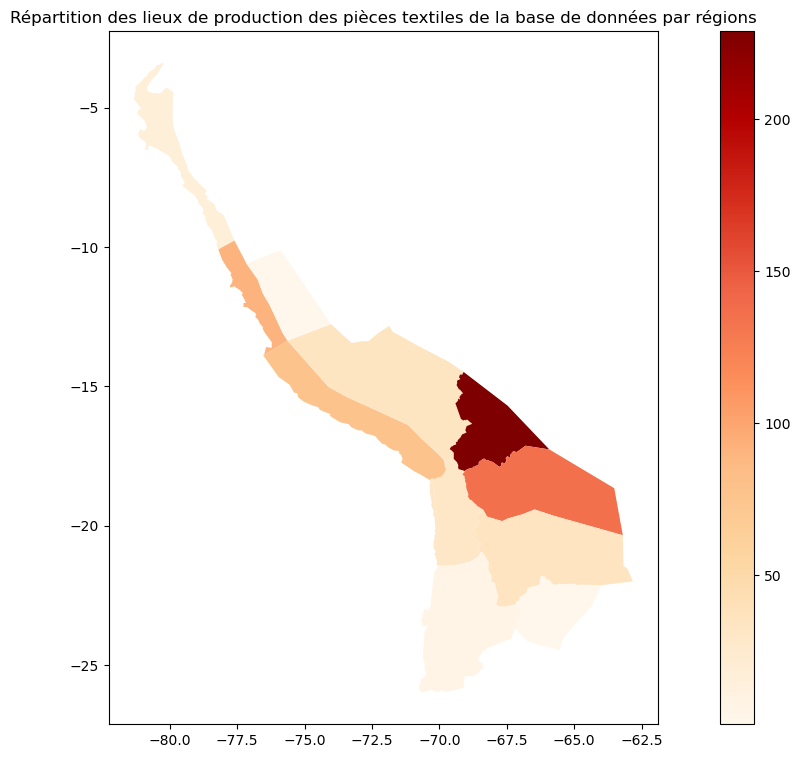

In [36]:
#Représentations cartographiques du décompte des lieux de production
textile_count_region_prod=textile_count_region_prod.drop(12, axis=0)

textile_count_region_prod.plot(
    column='count_region',
    figsize=(16, 9),
    cmap='OrRd', 
    #cmap='magma',
    legend=True,
)

plt.title("Répartition des lieux de production des pièces textiles de la base de données par régions")

#Ajout des étiquettes pour chaque polygone

plt.show()

In [37]:
#Représentations cartographiques interactives du décompte des lieux de production
textile_count_region_prod.explore(
     column="count_region", # make choropleth based on "BoroName" column
     tooltip="Name", # show "BoroName" value in tooltip (on hover)
     popup=True, # show all values in popup (on click)
     tiles="CartoDB positron", # use "CartoDB positron" tiles
     cmap="plasma", # use "Set1" matplotlib colormap
     style_kwds=dict(color="grey"),
     scheme='quantiles',
     k=5
    )

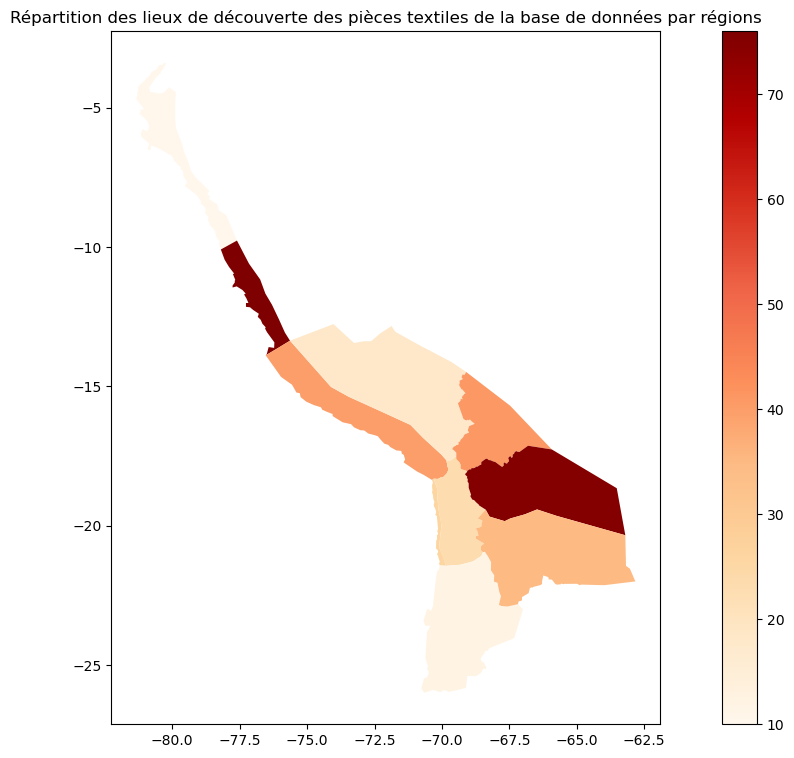

In [38]:
#Représentations cartographiques du décompte des lieux de découverte
#SUPPRESSION DE LA LIGNE RAPA NUI (DONNÉES NULLES) POUR AVOIR MEILLEURE VISIBILITÉ
textile_count_region_find=textile_count_region_find.drop(12, axis=0)

textile_count_region_find.plot(
    column='count_region',
    figsize=(16, 9),
    cmap='OrRd', 
    #cmap='magma',
    legend=True,
)

plt.title("Répartition des lieux de découverte des pièces textiles de la base de données par régions")

plt.show()

In [39]:
#Représentations cartographiques interactives du décompte des lieux de découverte
textile_count_region_find.explore(
     column="count_region", # make choropleth based on "BoroName" column
     tooltip="Name", # show "BoroName" value in tooltip (on hover)
     popup=True, # show all values in popup (on click)
     tiles="CartoDB positron", # use "CartoDB positron" tiles
     cmap="plasma", # use "Set1" matplotlib colormap
     style_kwds=dict(color="grey"),
     scheme='quantiles',
     k=5
    )

# Géocodage des données
## Cas pour production site

In [40]:
#Initialisation de la géo-localisation, on fait appel à l'API d'Open Street Map 'Nominatim'
geolocator = Nominatim(user_agent="LBL")

In [42]:
#Géocodage des lieux de production avec l'API d'Open Street Map
gdf_places_prod_temp = geopandas.GeoDataFrame()

geocode_prod = geopandas.GeoDataFrame() #Création d'un dataframe qui contiendra les informations géographiques

for elt in tqdm(geo_df_production['place']) :
    try : 
        location_variable = geolocator.geocode(elt)
        raw = location_variable.raw
        geometry = {"geometry":np.nan, "bbox_north":raw['boundingbox'][0], "bbox_south":raw['boundingbox'][1], "bbox_east":raw['boundingbox'][2], "bbox_west":raw['boundingbox'][3]}
        del raw['licence']
        del raw['boundingbox']
        geo_total = geometry | raw
    except : 
        print(elt)

    geocode_prod_temp = pd.DataFrame([geo_total])
    geocode_prod = pd.concat([geocode_prod, geocode_prod_temp ], ignore_index=True)

geocode_prod

100%|█████████████████████████████████████████| 696/696 [05:49<00:00,  1.99it/s]


,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,NaN,-19.2238056,-19.2182902,-65.8245213,-65.8195311,3689568,way,97061939,-19.2201563,-65.82247,place,village,19,0.346844,village,Tinguipaya,"Tinguipaya, Municipio Tinguipaya, Provincia To..."
1,NaN,-20.3705240,-20.3670792,-65.4665439,-65.4629459,3661012,way,605012571,-20.3687897,-65.4653828,place,village,19,0.275010,village,Calcha,"Calcha, Municipio Vitichi, Provincia Nor Chich..."
2,NaN,-20.3705240,-20.3670792,-65.4665439,-65.4629459,3661012,way,605012571,-20.3687897,-65.4653828,place,village,19,0.275010,village,Calcha,"Calcha, Municipio Vitichi, Provincia Nor Chich..."
3,NaN,-19.2238056,-19.2182902,-65.8245213,-65.8195311,3689568,way,97061939,-19.2201563,-65.82247,place,village,19,0.346844,village,Tinguipaya,"Tinguipaya, Municipio Tinguipaya, Provincia To..."
4,NaN,-18.8113571,-18.8033948,-65.5156050,-65.5054666,3634357,way,155478247,-18.8062996,-65.5117483,place,village,19,0.275010,village,Ravelo,"Ravelo, Municipio Ravelo, Provincia Chayanta, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,NaN,-27.4020000,-26.8550000,-109.6795789,-109.0029912,1995496,relation,14227159,-27.128500000000003,-109.33602969583333,boundary,maritime,25,0.415798,maritime,Rapa Nui,"Rapa Nui, Región de Valparaíso, 2770000, Chile"
692,NaN,-12.2658970,-12.2331621,-76.9169704,-76.8933039,3138085,relation,6553940,-12.2498244,-76.9067941784113,boundary,protected_area,25,0.430542,protected_area,Zona Arqueológica Monumental Pachacámac,"Zona Arqueológica Monumental Pachacámac, Lima,..."
693,NaN,-27.4020000,-26.8550000,-109.6795789,-109.0029912,1995496,relation,14227159,-27.128500000000003,-109.33602969583333,boundary,maritime,25,0.415798,maritime,Rapa Nui,"Rapa Nui, Región de Valparaíso, 2770000, Chile"
694,NaN,-14.4260547,-13.7548281,-76.3983632,-75.9808496,3280908,relation,1899041,-13.8350425,-76.2496219,boundary,administrative,16,0.308405,village,Paracas,"Paracas, Pisco, Ica, Perú"


In [43]:
df_prod_ID = geopandas.GeoDataFrame(df_production["ID"])
        
#Ajout des identifiants de chaque pièce
gdf_places_prod = df_prod_ID.merge(
    geocode_prod,
    left_index=True, 
    right_index=True,
    how='right'
)

gdf_places_prod

,ID,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,ILCA_ASU001,NaN,-19.2238056,-19.2182902,-65.8245213,-65.8195311,3689568,way,97061939,-19.2201563,-65.82247,place,village,19,0.346844,village,Tinguipaya,"Tinguipaya, Municipio Tinguipaya, Provincia To..."
1,ILCA_ASU002,NaN,-20.3705240,-20.3670792,-65.4665439,-65.4629459,3661012,way,605012571,-20.3687897,-65.4653828,place,village,19,0.275010,village,Calcha,"Calcha, Municipio Vitichi, Provincia Nor Chich..."
2,ILCA_ASU003,NaN,-20.3705240,-20.3670792,-65.4665439,-65.4629459,3661012,way,605012571,-20.3687897,-65.4653828,place,village,19,0.275010,village,Calcha,"Calcha, Municipio Vitichi, Provincia Nor Chich..."
3,ILCA_ASU004,NaN,-19.2238056,-19.2182902,-65.8245213,-65.8195311,3689568,way,97061939,-19.2201563,-65.82247,place,village,19,0.346844,village,Tinguipaya,"Tinguipaya, Municipio Tinguipaya, Provincia To..."
4,ILCA_ASU005,NaN,-18.8113571,-18.8033948,-65.5156050,-65.5054666,3634357,way,155478247,-18.8062996,-65.5117483,place,village,19,0.275010,village,Ravelo,"Ravelo, Municipio Ravelo, Provincia Chayanta, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,ILCA_VAM024,NaN,-27.4020000,-26.8550000,-109.6795789,-109.0029912,1995496,relation,14227159,-27.128500000000003,-109.33602969583333,boundary,maritime,25,0.415798,maritime,Rapa Nui,"Rapa Nui, Región de Valparaíso, 2770000, Chile"
692,ILCA_VAM025,NaN,-12.2658970,-12.2331621,-76.9169704,-76.8933039,3138085,relation,6553940,-12.2498244,-76.9067941784113,boundary,protected_area,25,0.430542,protected_area,Zona Arqueológica Monumental Pachacámac,"Zona Arqueológica Monumental Pachacámac, Lima,..."
693,ILCA_VAM026,NaN,-27.4020000,-26.8550000,-109.6795789,-109.0029912,1995496,relation,14227159,-27.128500000000003,-109.33602969583333,boundary,maritime,25,0.415798,maritime,Rapa Nui,"Rapa Nui, Región de Valparaíso, 2770000, Chile"
694,ILCA_VAM027,NaN,-14.4260547,-13.7548281,-76.3983632,-75.9808496,3280908,relation,1899041,-13.8350425,-76.2496219,boundary,administrative,16,0.308405,village,Paracas,"Paracas, Pisco, Ica, Perú"


In [47]:
#Création d'une géométrie "point" qu'on pourra ensuite cartographier
gdf_places_prod['geometry']=geopandas.points_from_xy(gdf_places_prod.lon, gdf_places_prod.lat)
gdf_places_prod

,ID,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,ILCA_ASU001,POINT (-65.82247 -19.22016),-19.2238056,-19.2182902,-65.8245213,-65.8195311,3689568,way,97061939,-19.2201563,-65.82247,place,village,19,0.346844,village,Tinguipaya,"Tinguipaya, Municipio Tinguipaya, Provincia To..."
1,ILCA_ASU002,POINT (-65.46538 -20.36879),-20.3705240,-20.3670792,-65.4665439,-65.4629459,3661012,way,605012571,-20.3687897,-65.4653828,place,village,19,0.275010,village,Calcha,"Calcha, Municipio Vitichi, Provincia Nor Chich..."
2,ILCA_ASU003,POINT (-65.46538 -20.36879),-20.3705240,-20.3670792,-65.4665439,-65.4629459,3661012,way,605012571,-20.3687897,-65.4653828,place,village,19,0.275010,village,Calcha,"Calcha, Municipio Vitichi, Provincia Nor Chich..."
3,ILCA_ASU004,POINT (-65.82247 -19.22016),-19.2238056,-19.2182902,-65.8245213,-65.8195311,3689568,way,97061939,-19.2201563,-65.82247,place,village,19,0.346844,village,Tinguipaya,"Tinguipaya, Municipio Tinguipaya, Provincia To..."
4,ILCA_ASU005,POINT (-65.51175 -18.80630),-18.8113571,-18.8033948,-65.5156050,-65.5054666,3634357,way,155478247,-18.8062996,-65.5117483,place,village,19,0.275010,village,Ravelo,"Ravelo, Municipio Ravelo, Provincia Chayanta, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,ILCA_VAM024,POINT (-109.33603 -27.12850),-27.4020000,-26.8550000,-109.6795789,-109.0029912,1995496,relation,14227159,-27.128500000000003,-109.33602969583333,boundary,maritime,25,0.415798,maritime,Rapa Nui,"Rapa Nui, Región de Valparaíso, 2770000, Chile"
692,ILCA_VAM025,POINT (-76.90679 -12.24982),-12.2658970,-12.2331621,-76.9169704,-76.8933039,3138085,relation,6553940,-12.2498244,-76.9067941784113,boundary,protected_area,25,0.430542,protected_area,Zona Arqueológica Monumental Pachacámac,"Zona Arqueológica Monumental Pachacámac, Lima,..."
693,ILCA_VAM026,POINT (-109.33603 -27.12850),-27.4020000,-26.8550000,-109.6795789,-109.0029912,1995496,relation,14227159,-27.128500000000003,-109.33602969583333,boundary,maritime,25,0.415798,maritime,Rapa Nui,"Rapa Nui, Región de Valparaíso, 2770000, Chile"
694,ILCA_VAM027,POINT (-76.24962 -13.83504),-14.4260547,-13.7548281,-76.3983632,-75.9808496,3280908,relation,1899041,-13.8350425,-76.2496219,boundary,administrative,16,0.308405,village,Paracas,"Paracas, Pisco, Ica, Perú"


La carte interactive produite à partir de ce traitement sont disponibles au lien suivant : https://lisebernard.github.io/carte_prod_clustering.html

## Cas pour find site

In [49]:
#Initialisation de la géo-localisation
geolocator = Nominatim(user_agent="LBL")

In [51]:
gdf_places_find_temp = geopandas.GeoDataFrame()

#Géocoder au niveau du point (avec nominatim)
geocode_find = geopandas.GeoDataFrame()

for elt in tqdm(geo_df_find['place']) :
    try : 
        location_variable = geolocator.geocode(elt)
        raw = location_variable.raw
        geometry = {"geometry":np.nan, "bbox_north":raw['boundingbox'][0], "bbox_south":raw['boundingbox'][1], "bbox_east":raw['boundingbox'][2], "bbox_west":raw['boundingbox'][3]}
        del raw['licence']
        del raw['boundingbox']
        geo_total = geometry | raw
    except :
        print(elt)
        
    geocode_find_temp = pd.DataFrame([geo_total])
    geocode_find = pd.concat([geocode_find, geocode_find_temp ], ignore_index=True)
        
geocode_find

100%|█████████████████████████████████████████| 696/696 [06:05<00:00,  1.91it/s]


,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,NaN,-19.2238056,-19.2182902,-65.8245213,-65.8195311,3689568,way,97061939,-19.2201563,-65.82247,place,village,19,0.346844,village,Tinguipaya,"Tinguipaya, Municipio Tinguipaya, Provincia To..."
1,NaN,-20.3705240,-20.3670792,-65.4665439,-65.4629459,3661012,way,605012571,-20.3687897,-65.4653828,place,village,19,0.275010,village,Calcha,"Calcha, Municipio Vitichi, Provincia Nor Chich..."
2,NaN,-20.3705240,-20.3670792,-65.4665439,-65.4629459,3661012,way,605012571,-20.3687897,-65.4653828,place,village,19,0.275010,village,Calcha,"Calcha, Municipio Vitichi, Provincia Nor Chich..."
3,NaN,-19.2238056,-19.2182902,-65.8245213,-65.8195311,3689568,way,97061939,-19.2201563,-65.82247,place,village,19,0.346844,village,Tinguipaya,"Tinguipaya, Municipio Tinguipaya, Provincia To..."
4,NaN,-18.8113571,-18.8033948,-65.5156050,-65.5054666,3634357,way,155478247,-18.8062996,-65.5117483,place,village,19,0.275010,village,Ravelo,"Ravelo, Municipio Ravelo, Provincia Chayanta, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,NaN,-12.5199316,-11.5724356,-77.1992129,-76.6208244,35725276,relation,12933390,-12.0621065,-77.0365256,boundary,administrative,10,0.673001,city,Lima Metropolitana,"Lima Metropolitana, Lima, Perú"
692,NaN,-12.5199316,-11.5724356,-77.1992129,-76.6208244,35725276,relation,12933390,-12.0621065,-77.0365256,boundary,administrative,10,0.673001,city,Lima Metropolitana,"Lima Metropolitana, Lima, Perú"
693,NaN,-12.5199316,-11.5724356,-77.1992129,-76.6208244,35725276,relation,12933390,-12.0621065,-77.0365256,boundary,administrative,10,0.673001,city,Lima Metropolitana,"Lima Metropolitana, Lima, Perú"
694,NaN,-27.4020000,-26.8550000,-109.6795789,-109.0029912,34568984,relation,14227159,-27.128500000000003,-109.33602969583333,boundary,maritime,25,0.415798,maritime,Rapa Nui,"Rapa Nui, Región de Valparaíso, 2770000, Chile"


In [52]:
df_find_ID = geopandas.GeoDataFrame(df_find["ID"])
        
#Ajout des identifiants de chaque pièce
gdf_places_find = df_find_ID.merge(
    geocode_find,
    left_index=True, 
    right_index=True,
    how='right'
)

gdf_places_find

,ID,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,ILCA_ASU001,NaN,-19.2238056,-19.2182902,-65.8245213,-65.8195311,3689568,way,97061939,-19.2201563,-65.82247,place,village,19,0.346844,village,Tinguipaya,"Tinguipaya, Municipio Tinguipaya, Provincia To..."
1,ILCA_ASU002,NaN,-20.3705240,-20.3670792,-65.4665439,-65.4629459,3661012,way,605012571,-20.3687897,-65.4653828,place,village,19,0.275010,village,Calcha,"Calcha, Municipio Vitichi, Provincia Nor Chich..."
2,ILCA_ASU003,NaN,-20.3705240,-20.3670792,-65.4665439,-65.4629459,3661012,way,605012571,-20.3687897,-65.4653828,place,village,19,0.275010,village,Calcha,"Calcha, Municipio Vitichi, Provincia Nor Chich..."
3,ILCA_ASU004,NaN,-19.2238056,-19.2182902,-65.8245213,-65.8195311,3689568,way,97061939,-19.2201563,-65.82247,place,village,19,0.346844,village,Tinguipaya,"Tinguipaya, Municipio Tinguipaya, Provincia To..."
4,ILCA_ASU005,NaN,-18.8113571,-18.8033948,-65.5156050,-65.5054666,3634357,way,155478247,-18.8062996,-65.5117483,place,village,19,0.275010,village,Ravelo,"Ravelo, Municipio Ravelo, Provincia Chayanta, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,ILCA_VAM024,NaN,-12.5199316,-11.5724356,-77.1992129,-76.6208244,35725276,relation,12933390,-12.0621065,-77.0365256,boundary,administrative,10,0.673001,city,Lima Metropolitana,"Lima Metropolitana, Lima, Perú"
692,ILCA_VAM025,NaN,-12.5199316,-11.5724356,-77.1992129,-76.6208244,35725276,relation,12933390,-12.0621065,-77.0365256,boundary,administrative,10,0.673001,city,Lima Metropolitana,"Lima Metropolitana, Lima, Perú"
693,ILCA_VAM026,NaN,-12.5199316,-11.5724356,-77.1992129,-76.6208244,35725276,relation,12933390,-12.0621065,-77.0365256,boundary,administrative,10,0.673001,city,Lima Metropolitana,"Lima Metropolitana, Lima, Perú"
694,ILCA_VAM027,NaN,-27.4020000,-26.8550000,-109.6795789,-109.0029912,34568984,relation,14227159,-27.128500000000003,-109.33602969583333,boundary,maritime,25,0.415798,maritime,Rapa Nui,"Rapa Nui, Región de Valparaíso, 2770000, Chile"


In [53]:
#Création d'une géométrie "point" qu'on pourra ensuite cartographier
gdf_places_find['geometry']=geopandas.points_from_xy(gdf_places_find.lon, gdf_places_find.lat)
gdf_places_find

,ID,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,ILCA_ASU001,POINT (-65.82247 -19.22016),-19.2238056,-19.2182902,-65.8245213,-65.8195311,3689568,way,97061939,-19.2201563,-65.82247,place,village,19,0.346844,village,Tinguipaya,"Tinguipaya, Municipio Tinguipaya, Provincia To..."
1,ILCA_ASU002,POINT (-65.46538 -20.36879),-20.3705240,-20.3670792,-65.4665439,-65.4629459,3661012,way,605012571,-20.3687897,-65.4653828,place,village,19,0.275010,village,Calcha,"Calcha, Municipio Vitichi, Provincia Nor Chich..."
2,ILCA_ASU003,POINT (-65.46538 -20.36879),-20.3705240,-20.3670792,-65.4665439,-65.4629459,3661012,way,605012571,-20.3687897,-65.4653828,place,village,19,0.275010,village,Calcha,"Calcha, Municipio Vitichi, Provincia Nor Chich..."
3,ILCA_ASU004,POINT (-65.82247 -19.22016),-19.2238056,-19.2182902,-65.8245213,-65.8195311,3689568,way,97061939,-19.2201563,-65.82247,place,village,19,0.346844,village,Tinguipaya,"Tinguipaya, Municipio Tinguipaya, Provincia To..."
4,ILCA_ASU005,POINT (-65.51175 -18.80630),-18.8113571,-18.8033948,-65.5156050,-65.5054666,3634357,way,155478247,-18.8062996,-65.5117483,place,village,19,0.275010,village,Ravelo,"Ravelo, Municipio Ravelo, Provincia Chayanta, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,ILCA_VAM024,POINT (-77.03653 -12.06211),-12.5199316,-11.5724356,-77.1992129,-76.6208244,35725276,relation,12933390,-12.0621065,-77.0365256,boundary,administrative,10,0.673001,city,Lima Metropolitana,"Lima Metropolitana, Lima, Perú"
692,ILCA_VAM025,POINT (-77.03653 -12.06211),-12.5199316,-11.5724356,-77.1992129,-76.6208244,35725276,relation,12933390,-12.0621065,-77.0365256,boundary,administrative,10,0.673001,city,Lima Metropolitana,"Lima Metropolitana, Lima, Perú"
693,ILCA_VAM026,POINT (-77.03653 -12.06211),-12.5199316,-11.5724356,-77.1992129,-76.6208244,35725276,relation,12933390,-12.0621065,-77.0365256,boundary,administrative,10,0.673001,city,Lima Metropolitana,"Lima Metropolitana, Lima, Perú"
694,ILCA_VAM027,POINT (-109.33603 -27.12850),-27.4020000,-26.8550000,-109.6795789,-109.0029912,34568984,relation,14227159,-27.128500000000003,-109.33602969583333,boundary,maritime,25,0.415798,maritime,Rapa Nui,"Rapa Nui, Región de Valparaíso, 2770000, Chile"


La carte interactive produite à partir de ce traitement sont disponibles au lien suivant : https://lisebernard.github.io/carte_find_clustering.html

# Vérification du géocodage

In [68]:
gdf_region = geopandas.read_file("geo_data/WCP_region3.shp", crs=4326)
del gdf_region['id']
print(gdf_region)

                 Name                                           geometry
0         North coast  POLYGON ((-78.17975 -10.07898, -78.20002 -10.0...
1       Central coast  POLYGON ((-78.20002 -10.08896, -77.60203 -9.76...
2         South coast  POLYGON ((-76.53613 -13.88622, -76.07184 -13.6...
3         Arica coast  POLYGON ((-70.36466 -18.35937, -70.30753 -18.3...
4      Arica Interior  POLYGON ((-69.74661 -17.65895, -69.65054 -17.6...
5       Atacama Basin  POLYGON ((-70.08344 -21.42282, -69.84789 -21.4...
6                 NOA  POLYGON ((-63.98218 -22.13301, -64.36038 -22.9...
7        South sierra  POLYGON ((-75.63436 -13.36168, -74.02159 -12.7...
8     North Altiplano  POLYGON ((-69.12449 -15.24663, -69.24068 -15.1...
9   Central Altiplano  POLYGON ((-66.80681 -17.12977, -65.92396 -17.2...
10    South Altiplano  POLYGON ((-63.19807 -20.34090, -63.17422 -21.4...
11     Central Sierra  POLYGON ((-77.15607 -10.59747, -75.89573 -10.1...
12           Rapa Nui  POLYGON ((-109.45651 -27.187

### Production site

In [77]:
#On vérifie si les points localisés se situent dans les régions

point = geopandas.GeoDataFrame(gdf_places_prod['geometry'], crs=4326)

region_gdf_temp = geopandas.GeoDataFrame(geo_df_production['region'].rename("Name"))

#au moment du merge la région central sierra disparaît puisqu'elle n'est associée à aucun point précis.
region = region_gdf_temp.merge(gdf_region, how='left', on='Name')
region_geoserie = geopandas.GeoSeries(region['geometry'])

verif = point.within(region_geoserie, align=False)

#Tableau de vérification
geo_df_production_fin = geo_df_production
geo_df_production_fin['place_point'] = point
geo_df_production_fin['region_polygon'] = region_geoserie
geo_df_production_fin['verif_geocode'] = verif

print(geo_df_production_fin['verif_geocode'].value_counts())
geo_df_production_fin

verif_geocode
True     585
False    111
Name: count, dtype: int64


,ID,production site,country,region,place,place_point,region_polygon,verif_geocode,verif_NaN
0,ILCA_ASU001,"Ayllu Tinkipaya, Bolivia, Central Interandean ...",Bolivia,Central Altiplano,Tinguipaya,POINT (-65.82247 -19.22016),"POLYGON ((-66.80681 -17.12977, -65.92396 -17.2...",True,True
1,ILCA_ASU002,"Bolivia, Calcha, Southern Interandean Valleys",Bolivia,South Altiplano,Calcha,POINT (-65.46538 -20.36879),"POLYGON ((-63.19807 -20.34090, -63.17422 -21.4...",True,True
2,ILCA_ASU003,"Bolivia, Calcha, Southern Interandean Valleys",Bolivia,South Altiplano,Calcha,POINT (-65.46538 -20.36879),"POLYGON ((-63.19807 -20.34090, -63.17422 -21.4...",True,True
3,ILCA_ASU004,"Ayllu Tinkipaya, Bolivia, Central Interandean ...",Bolivia,Central Altiplano,Tinguipaya,POINT (-65.82247 -19.22016),"POLYGON ((-66.80681 -17.12977, -65.92396 -17.2...",True,True
4,ILCA_ASU005,"Bolivia, Central Interandean Valleys, Ravelo",Bolivia,Central Altiplano,Ravelo,POINT (-65.51175 -18.80630),"POLYGON ((-66.80681 -17.12977, -65.92396 -17.2...",True,True
...,...,...,...,...,...,...,...,...,...
691,ILCA_VAM024,"Central coast, Peru",Peru,Central coast,Rapa Nui,POINT (-109.33603 -27.12850),"POLYGON ((-78.20002 -10.08896, -77.60203 -9.76...",False,True
692,ILCA_VAM025,"Central coast, Pachacamac, Peru",Peru,Central coast,Pachacamac,POINT (-76.90679 -12.24982),"POLYGON ((-78.20002 -10.08896, -77.60203 -9.76...",True,True
693,ILCA_VAM026,"Central coast, Peru",Peru,Central coast,Rapa Nui,POINT (-109.33603 -27.12850),"POLYGON ((-78.20002 -10.08896, -77.60203 -9.76...",False,True
694,ILCA_VAM027,"Paracas, Peru, South coast",Peru,South coast,Paracas,POINT (-76.24962 -13.83504),"POLYGON ((-76.53613 -13.88622, -76.07184 -13.6...",True,True


In [71]:
#Tableau qui décompte les erreurs de géocodage en prenant en compte la valeur 'Rapa Nui'
geo_df_production_fin['verif_NaN'] = geo_df_production_fin['verif_geocode']
geo_df_production_fin.loc[geo_df_production_fin['place'] == 'Rapa Nui', 'verif_NaN'] = True

print(geo_df_production_fin['verif_NaN'].value_counts())

verif_NaN
True     678
False     18
Name: count, dtype: int64


In [73]:
#Récupérer les identifiants des textiles qui sont mal géocodés : on affiche le lieu et la région
df_erreur = geo_df_production_fin.loc[geo_df_production_fin['verif_NaN'] == False]
df_erreur

,ID,production site,country,region,place,place_point,region_polygon,verif_geocode,verif_NaN
120,ILCA_BML116,"Bolivia, North Altiplano, Region of lake Titic...",Bolivia,North Altiplano,Lake Titicaca,POINT (-69.68886 -15.76696),"POLYGON ((-69.12449 -15.24663, -69.24068 -15.1...",False,False
130,ILCA_BML128,"Bolivia, North Altiplano, Region of lake Titic...",Bolivia,North Altiplano,Lake Titicaca,POINT (-69.68886 -15.76696),"POLYGON ((-69.12449 -15.24663, -69.24068 -15.1...",False,False
152,ILCA_BML151,"Bolivia, North Altiplano, Region of lake Titic...",Bolivia,North Altiplano,Lake Titicaca,POINT (-69.68886 -15.76696),"POLYGON ((-69.12449 -15.24663, -69.24068 -15.1...",False,False
153,ILCA_BML152,"Bolivia, North Altiplano, Region of lake Titic...",Bolivia,North Altiplano,Lake Titicaca,POINT (-69.68886 -15.76696),"POLYGON ((-69.12449 -15.24663, -69.24068 -15.1...",False,False
154,ILCA_BML153,"Bolivia, North Altiplano, Region of lake Titic...",Bolivia,North Altiplano,Lake Titicaca,POINT (-69.68886 -15.76696),"POLYGON ((-69.12449 -15.24663, -69.24068 -15.1...",False,False
155,ILCA_BML155_SR,"Bolivia, North Altiplano, Region of lake Titic...",Bolivia,North Altiplano,Lake Titicaca,POINT (-69.68886 -15.76696),"POLYGON ((-69.12449 -15.24663, -69.24068 -15.1...",False,False
213,ILCA_ILCA040,"Bolivia, Islas del lago Titicaca, North Altiplano",Bolivia,North Altiplano,Lake Titicaca,POINT (-69.68886 -15.76696),"POLYGON ((-69.12449 -15.24663, -69.24068 -15.1...",False,False
286,ILCA_MAN006,"Bolivia, North Altiplano, Region of lake Titic...",Bolivia,North Altiplano,Lake Titicaca,POINT (-69.68886 -15.76696),"POLYGON ((-69.12449 -15.24663, -69.24068 -15.1...",False,False
519,ILCA_MNA007,"Bolivia, North Altiplano, Region of lake Titic...",Bolivia,North Altiplano,Lake Titicaca,POINT (-69.68886 -15.76696),"POLYGON ((-69.12449 -15.24663, -69.24068 -15.1...",False,False
539,ILCA_MNA037,"Bolivia, North Altiplano, Tiwanaku",Bolivia,North Altiplano,Lake Titicaca,POINT (-69.68886 -15.76696),"POLYGON ((-69.12449 -15.24663, -69.24068 -15.1...",False,False


In [74]:
#Visualisation des erreurs
carte = folium.Map([-19, -70], tiles="OpenTopoMap",zoom_start=4)

for _, r in df_erreur.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = geopandas.GeoSeries(r["region_polygon"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    folium.Popup(r["region"]).add_to(geo_j)
    geo_j.add_to(carte)

for _, r in df_erreur.iterrows():
    lat = r["place_point"].y
    lon = r["place_point"].x
    folium.Marker(
        location=[lat, lon],
        popup="region: {} <br> place: {}".format(r["region"], r["place"])
        #Voir région et lieu permet de voir d'où vient erreur : frontière ou géolocalisation
    ).add_to(carte)
    
carte

### Find site

In [76]:
#On vérifie si les points localisés se situent dans les régions

point = geopandas.GeoDataFrame(gdf_places_find['geometry'], crs=4326)

region_gdf_temp = geopandas.GeoDataFrame(geo_df_find['region'].rename("Name"))
region = region_gdf_temp.merge(gdf_region, how='left', on='Name')
region_geoserie = geopandas.GeoSeries(region['geometry'])

verif = point.within(region_geoserie, align=False)

#Tableau de vérification
geo_df_find_fin = geo_df_find
geo_df_find_fin['place_point'] = point
geo_df_find_fin['region_polygon'] = region_geoserie
geo_df_find_fin['verif_geocode'] = verif

print(geo_df_find_fin['verif_geocode'].value_counts())
geo_df_find_fin

verif_geocode
True     527
False    169
Name: count, dtype: int64


,ID,find site,country,region,place,place_point,region_polygon,verif_geocode,verif_NaN
0,ILCA_ASU001,"Ayllu Tinkipaya, Bolivia, Central Interandean ...",Bolivia,Central Altiplano,Tinguipaya,POINT (-65.82247 -19.22016),"POLYGON ((-66.80681 -17.12977, -65.92396 -17.2...",True,True
1,ILCA_ASU002,"Bolivia, Calcha, Southern Interandean Valleys",Bolivia,South Altiplano,Calcha,POINT (-65.46538 -20.36879),"POLYGON ((-63.19807 -20.34090, -63.17422 -21.4...",True,True
2,ILCA_ASU003,"Bolivia, Calcha, Southern Interandean Valleys",Bolivia,South Altiplano,Calcha,POINT (-65.46538 -20.36879),"POLYGON ((-63.19807 -20.34090, -63.17422 -21.4...",True,True
3,ILCA_ASU004,"Ayllu Tinkipaya, Bolivia, Central Interandean ...",Bolivia,Central Altiplano,Tinguipaya,POINT (-65.82247 -19.22016),"POLYGON ((-66.80681 -17.12977, -65.92396 -17.2...",True,True
4,ILCA_ASU005,"Bolivia, Central Interandean Valleys, Ravelo",Bolivia,Central Altiplano,Ravelo,POINT (-65.51175 -18.80630),"POLYGON ((-66.80681 -17.12977, -65.92396 -17.2...",True,True
...,...,...,...,...,...,...,...,...,...
691,ILCA_VAM024,"Central coast, Lima, Peru",Peru,Central coast,Lima Metropolitana,POINT (-77.03653 -12.06211),"POLYGON ((-78.20002 -10.08896, -77.60203 -9.76...",True,True
692,ILCA_VAM025,"Central coast, Lima, Peru",Peru,Central coast,Lima Metropolitana,POINT (-77.03653 -12.06211),"POLYGON ((-78.20002 -10.08896, -77.60203 -9.76...",True,True
693,ILCA_VAM026,"Central coast, Lima, Peru",Peru,Central coast,Lima Metropolitana,POINT (-77.03653 -12.06211),"POLYGON ((-78.20002 -10.08896, -77.60203 -9.76...",True,True
694,ILCA_VAM027,"Peru, South coast",Peru,South coast,Rapa Nui,POINT (-109.33603 -27.12850),"POLYGON ((-76.53613 -13.88622, -76.07184 -13.6...",False,True


In [78]:
#Prise en compte des valeurs 'Rapa Nui'
geo_df_find_fin['verif_NaN'] = geo_df_find_fin['verif_geocode']
geo_df_find_fin.loc[geo_df_find_fin['place'] == 'Rapa Nui', 'verif_NaN'] = True


print(geo_df_find_fin['verif_NaN'].value_counts())

verif_NaN
True     692
False      4
Name: count, dtype: int64


In [66]:
df_erreur = geo_df_find_fin.loc[geo_df_find_fin['verif_NaN'] == False]
df_erreur

,ID,find site,country,region,place,place_point,region_polygon,verif_geocode,verif_NaN
152,ILCA_BML151,"Bolivia, North Altiplano, Region of lake Titic...",Bolivia,North Altiplano,Lake Titicaca,POINT (-69.68886 -15.76696),"POLYGON ((-69.12449 -15.24663, -69.24068 -15.1...",False,False
153,ILCA_BML152,"Bolivia, North Altiplano, Region of lake Titic...",Bolivia,North Altiplano,Lake Titicaca,POINT (-69.68886 -15.76696),"POLYGON ((-69.12449 -15.24663, -69.24068 -15.1...",False,False
154,ILCA_BML153,"Bolivia, North Altiplano, Region of lake Titic...",Bolivia,North Altiplano,Lake Titicaca,POINT (-69.68886 -15.76696),"POLYGON ((-69.12449 -15.24663, -69.24068 -15.1...",False,False
519,ILCA_MNA007,"Bolivia, North Altiplano, Region of lake Titic...",Bolivia,North Altiplano,Lake Titicaca,POINT (-69.68886 -15.76696),"POLYGON ((-69.12449 -15.24663, -69.24068 -15.1...",False,False


In [79]:
#Visualisation des erreurs
carte = folium.Map([-19, -70], tiles="OpenTopoMap",zoom_start=4)

for _, r in df_erreur.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = geopandas.GeoSeries(r["region_polygon"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    folium.Popup(r["region"]).add_to(geo_j)
    geo_j.add_to(carte)
    
for _, r in df_erreur.iterrows():
    lat = r["place_point"].y
    lon = r["place_point"].x
    folium.Marker(
        location=[lat, lon],
        popup="region: {} <br> place: {}".format(r["region"], r["place"])
    ).add_to(carte)
    
carte

## Préparation des documents json pour cartographie interactive GitHub

In [80]:
import json

In [81]:
with open('gdf_prod.csv') as csv :
    gdf_places_prod = pd.read_csv(csv, sep="\t")
    
with open('gdf_find.csv') as csv :
    gdf_places_find = pd.read_csv(csv, sep="\t")

In [84]:
adresse = []
for i in range(696) : 
        im_name = df_textile['image'][i]
        im_name = im_name.split()[0]
        im_name = im_name.replace("[", "")
        im_name = im_name.replace("]", "")
        im_name = im_name.replace("'", "")
        im_name = im_name.replace(",", "")

        adresse.append(im_name)

#### Cas lieux de production

In [85]:
#Création d'un document .json contenant les latitudes, les longitudes, les ID des textiles et les noms de lieux de production pour chaque textiles. 

dico_lat = {}
dico_lon = {}
dico_ID = {}
dico_lieu = {}
dico_image = {}

for i in range(696) : 
    dico_lat[f'{i}'] = float(gdf_places_prod.loc[i, "lat"])
    dico_lon[f'{i}'] = float(gdf_places_prod.loc[i, "lon"])
    dico_ID[f'{i}'] = gdf_places_prod.loc[i, "ID"]
    dico_lieu[f'{i}'] = gdf_places_prod.loc[i, "name"]
    dico_image[f'{i}'] = adresse[i]
    

dico_prod = {}
dico_prod['Latitude'] = dico_lat
dico_prod['Longitude'] = dico_lon
dico_prod['ID'] = dico_ID
dico_prod['Lieux'] = dico_lieu
dico_prod['Images'] = dico_image

dico_prod

with open("data_map_prod.json", "w") as write_file:
    json.dump(dico_prod, write_file)

In [89]:
#Creation d'une couche de chaleur sous forme de liste de listes contenant la latitude, la longitude et le nombre d'élemtn par point : 

#print(gdf_places_prod)
count_region_prod = gdf_places_prod.groupby(['name'],
    as_index=True,
)['name'].count()

mainlist = []
name = []

for elt in count_region_prod.index.to_list(): 
    latlonheat = []
    latlonheat.append(gdf_places_prod.loc[gdf_places_prod['name'] == elt, 'lat'].values[0])
    latlonheat.append(gdf_places_prod.loc[gdf_places_prod['name'] == elt, 'lon'].values[0])
    latlonheat.append(count_region_prod.loc[elt])
    name.append(elt)
    mainlist.append(latlonheat)

La carte de densité interactive pour les lieux de production se trouve au lien suivant : https://lisebernard.github.io/heatmap_prod.html

#### Cas lieux de production

In [87]:
#Création d'un document .json contenant les latitudes, les longitudes, les ID des textiles et les noms de lieux de découverte pour chaque textiles. 
dico_lat = {}
dico_lon = {}
dico_ID = {}
dico_lieu = {}

for i in range(696) : 
    dico_lat[f'{i}'] = float(gdf_places_find.loc[i, "lat"])
    dico_lon[f'{i}'] = float(gdf_places_find.loc[i, "lon"])
    dico_ID[f'{i}'] = gdf_places_find.loc[i, "ID"]
    dico_lieu[f'{i}'] = gdf_places_find.loc[i, "name"]
    dico_image[f'{i}'] = adresse[i]

dico_find = {}
dico_find['Latitude'] = dico_lat
dico_find['Longitude'] = dico_lon
dico_find['ID'] = dico_ID
dico_find['Lieux'] = dico_lieu
dico_find['Images'] = dico_image

dico_find

with open("data_map_find.json", "w") as write_file:
    json.dump(dico_find, write_file)

In [91]:
#Creation d'une couche de chaleur sous forme de liste de listes contenant la latitude, la longitude et le nombre d'élemtn par point : 

#print(gdf_places_prod)
count_region_find = gdf_places_find.groupby(['name'],
    as_index=True,
)['name'].count()

mainlist = []
name = []

for elt in count_region_find.index.to_list(): 
    latlonheat = []
    latlonheat.append(gdf_places_find.loc[gdf_places_find['name'] == elt, 'lat'].values[0])
    latlonheat.append(gdf_places_find.loc[gdf_places_find['name'] == elt, 'lon'].values[0])
    latlonheat.append(count_region_find.loc[elt])
    name.append(elt)
    mainlist.append(latlonheat)

La carte de densité interactive pour les lieux de découverte se trouve au lien suivant : https://lisebernard.github.io/heatmap_find.html

## Extraction des dataframes géocodés pour les traiter

In [92]:
#gdf_places_prod.to_csv('gdf_prod.csv',sep='\t', encoding='utf-8', index=False)
#gdf_places_find.to_csv('gdf_find.csv',sep='\t', encoding='utf-8', index=False)